# Baseline Model

This is the code used to generate the days improvement metric for the baseline model. Previously, we found the failure rate of regular canvass inspections in each community area. For the baseline model, we assigned each restaurant a probability of failure equal to the failure rate of its community area. Inspecting the restaurants in descending order of estimated failure probability (random order in the case of ties) would have resulted in finding restaurants inspected from July 2016 through October 2016 (this was our test set) that failed their inspections an average of 4.6 days earlier than they were actually found.

In [1]:
# import modules
import numpy as np
import pandas as pd
import scipy as sp
import math
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
import csv
import StringIO
import string

In [2]:
# load data with pass rates by community area and full dataset
comm_area_prob_fail_df = pd.read_csv('baseline 2.csv')
canvass_full = pd.read_csv('canvass_full.csv')

In [3]:
# column names for community area/pass rate dataset
comm_area_prob_fail_df.columns

Index([u'Community Area', u'COMMUNITY AREA NAME', u'pass_prob'], dtype='object')

In [4]:
# function to calculate avg days improvement for the baseline model
# baseline assigns probability of passing to restaurant using the pass probability of its community area
def avg_days_improvement_baseline():
    
    global canvass_full
    global comm_area_prob_fail_df
    baseline_2 = pd.merge(canvass_full, comm_area_prob_fail_df, how = 'left', on = ['Community Area', 'COMMUNITY AREA NAME'])

    baseline_proba_test = baseline_2[(baseline_2['Inspection Date'] >= '2016-07-01') & (baseline_2['Inspection Date'] < '2016-11-01')].loc[:, ('pass_prob', 'Results')]
    baseline_proba_test_sort = baseline_proba_test.sort_values(['pass_prob'])

    inspection_date_test = baseline_2['Inspection Date'][(baseline_2['Inspection Date'] >= '2016-07-01') & (baseline_2['Inspection Date'] < '2016-11-01')]
    inspection_date_test_sort = inspection_date_test.sort_values().values

    baseline_proba_test_sort['Inspection Date 2'] = pd.Series(inspection_date_test_sort, index = baseline_proba_test_sort.index)

    truth = baseline_2[(baseline_2['Inspection Date'] >= '2016-07-01') & (baseline_2['Inspection Date'] < '2016-11-01')].loc[:, ('Inspection Date', 'Results')]

    combined = pd.concat([truth, baseline_proba_test_sort], axis = 1)
    combined_2 = combined.iloc[:, (0, 1, 2, 4)]

    fail_df = combined_2[combined_2['Results'] == 'Fail']
    fail_df['Original - New'] = pd.Series(pd.to_datetime(fail_df['Inspection Date']) - pd.to_datetime(fail_df['Inspection Date 2']))

    mean_improvement = np.mean(fail_df['Original - New'])
    days_improvement = mean_improvement.days
    day_fraction = mean_improvement.seconds/(24.0 * 60 * 60)

    improvement_vec = np.array(fail_df['Original - New']) * (1.15741 * (10 ** -14))
    improvement_vec_2 = [int(improvement_vec[i]) for i in range(len(improvement_vec))]
    
    return days_improvement + day_fraction, improvement_vec_2, fail_df

C:\Users\chris\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


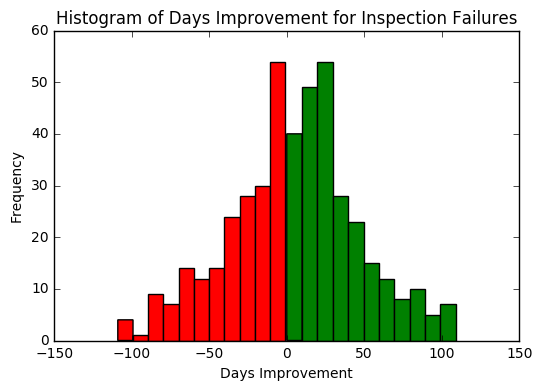

Avg days improvement: 4.64954861111
Median days improvement: 6.0
Standard deviation of days improvement: 41.7501063918
Proportion of failures found earlier or same: 0.560267857143
Proportion of failures that would have been found in July and August using baseline: 0.691964285714
Proportion of failures actually found in July and August: 0.683035714286


In [5]:
# histogram of days improvement for baseline model
days_improve_4 = avg_days_improvement_baseline()

positive_4 = [days_improve_4[1][i] for i in range(len(days_improve_4[1])) if days_improve_4[1][i] >= 0]
negative_4 = [days_improve_4[1][i] for i in range(len(days_improve_4[1])) if days_improve_4[1][i] < 0]
plt.hist(positive_4, bins = 11, color = 'g')
plt.hist(negative_4, bins = 11, color = 'r')
plt.title('Histogram of Days Improvement for Inspection Failures')
plt.xlabel('Days Improvement')
plt.ylabel('Frequency')
plt.show()
print 'Avg days improvement: ' + str(days_improve_4[0])
print 'Median days improvement: ' + str(np.median(days_improve_4[1]))
print 'Standard deviation of days improvement: ' + str(np.std(days_improve_4[1]))
print 'Proportion of failures found earlier or same: ' + str(len(positive_4)/float(len(days_improve_4[1])))
print 'Proportion of failures that would have been found in July and August using baseline: ' + str(len(days_improve_4[2][days_improve_4[2]['Inspection Date 2'] < '2016-09-01'])/float(len(days_improve_4[2])))
print 'Proportion of failures actually found in July and August: ' + str(len(days_improve_4[2][days_improve_4[2]['Inspection Date'] < '2016-09-01'])/float(len(days_improve_4[2])))